In [1]:
# !pip install ultralytics

In [2]:
# import section

from PIL import Image, ImageFilter, ImageEnhance, ImageOps
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms

In [3]:
# Set execution backend (CPU/MPS/GPU)

device = (
    "cuda" if torch.cuda.is_available() # CUDA-capable GPUs
    else "mps" if torch.backends.mps.is_available() # For MacOS systems
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [4]:
# Set up label encodings and data paths

label_encodings = ['bicycle', 'bus', 'car', 'motorbike', 'person']
data_paths = {
    "train": {
        "images": Path("./Street-View-1/train/images"),
        "labels": Path("./Street-View-1/train/labels"),
    },
    "test": {
        "images": Path("./Street-View-1/test/images"),
        "labels": Path("./Street-View-1/test/labels"),
    },
    "val": {
        "images": Path("./Street-View-1/val/images"),
        "labels": Path("./Street-View-1/val/labels"),
    },
}

In [5]:
# Create function to prepare input data

def data_sort(set_type):
    img_paths = [path.resolve() for path in data_paths[set_type]['images'].rglob('*')]
    targets = []
    for label_path in data_paths[set_type]['labels'].rglob('*'):
        with open(str(label_path), 'r') as fp:
            labels = []
            boxes = []
            target = {}
            for line in fp:
                data = line.strip().split(" ")
                labels.append(int(data.pop(0)))
                boxes.append([float(i) for i in data])
            target['labels'] = labels
            target['boxes'] = boxes
            targets.append(target)
    
    return img_paths, targets

In [6]:
train_img_paths, train_targets = data_sort('train')
train_targets[0]

{'labels': [0, 0, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 'boxes': [[0.4984375, 0.9078125, 0.0453125, 0.18125],
  [0.5375, 0.86640625, 0.0390625, 0.16875],
  [0.63671875, 0.27421875, 0.021875, 0.0765625],
  [0.89296875, 0.4421875, 0.209375, 0.2453125],
  [0.7765625, 0.27265625, 0.0640625, 0.0859375],
  [0.57578125, 0.2046875, 0.0390625, 0.0671875],
  [0.63359375, 0.20546875, 0.0390625, 0.0703125],
  [0.59765625, 0.16328125, 0.034375, 0.0578125],
  [0.646875, 0.1703125, 0.0390625, 0.0609375],
  [0.615625, 0.12890625, 0.0328125, 0.0515625],
  [0.65625, 0.1265625, 0.025, 0.04375],
  [0.6265625, 0.10546875, 0.0265625, 0.04375],
  [0.63828125, 0.08203125, 0.0265625, 0.0390625],
  [0.64453125, 0.05859375, 0.0265625, 0.0453125],
  [0.65625, 0.046875, 0.0203125, 0.034375],
  [0.67421875, 0.084375, 0.0296875, 0.0453125],
  [0.6828125, 0.0640625, 0.021875, 0.034375]]}

In [7]:
from ultralytics import YOLO

model = YOLO('yolov5n.yaml').load('yolov5nu.pt')
yaml_path = Path('./Street-View-1/data.yaml').resolve()
results = model.train(data=str(yaml_path), epochs=10, imgsz=640)


                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [8]:
images = Image.open(train_img_paths[5])
results = model(images)[0]


0: 640x640 1 bicycle, 18 cars, 10 motorbikes, 31.3ms
Speed: 15.6ms preprocess, 31.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


In [9]:
counter = 0
for label in results.boxes.cls:
    if label not in [0., 4.]:
        counter += 1

print(f"There are {counter} vehicles on the road")

There are 28 vehicles on the road


# Use Saved fine-tuned model

In [10]:
from ultralytics import YOLO
from PIL import Image
from pathlib import Path

In [27]:
# Load model with fine-tuned weights

data_yaml_path = Path('./Street-View-1/data.yaml').resolve()
weight_pt_path = Path('./runs/detect/train4/weights/best.pt').resolve()
model = YOLO(str(weight_pt_path))

In [12]:
test_img_paths, test_targets = data_sort('test')

In [13]:
# images = Image.open(train_img_paths[5])
# images

In [14]:
results = model.predict(test_img_paths[5], imgsz=640, show=True, save=True, classes=[1, 2, 3], conf=0.5)

WARNING  Environment does not support cv2.imshow() or PIL Image.show()
OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


image 1/1 C:\Users\rahul\Desktop\Jupyter_Code\ML_NJIT\AI_Assignments\Traffic_Detection_YOLOv5\Street-View-1\test\images\aguanambi-1680_png_jpg.rf.fede1a51e422cc8fd628a4846615f65f.jpg: 640x640 (no detections), 31.8ms
Speed: 15.6ms preprocess, 31.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict2


In [15]:
counter = 0
for label in results[0].boxes.cls:
    if label not in [0., 4.]:
        counter += 1

print(f"There are {counter} vehicles on the road")

There are 0 vehicles on the road


In [16]:
results[0].boxes.cls

tensor([], device='cuda:0')

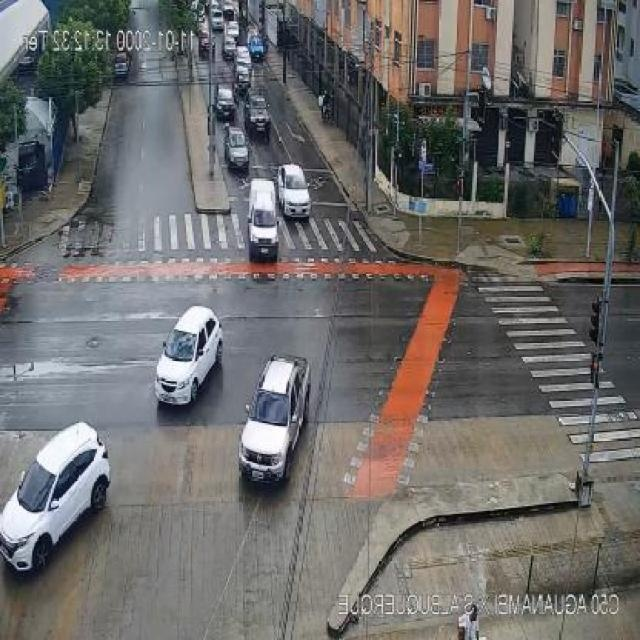

In [17]:
Image.open(Path('./runs/detect/predict/aguanambi-1680_png_jpg.rf.fede1a51e422cc8fd628a4846615f65f.jpg'))

In [28]:
metrics = model.val()
conf_mat = metrics.confusion_matrix
total_events = sum(sum(conf_mat.matrix))

Ultralytics YOLOv8.0.208  Python-3.11.1 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv5n summary (fused): 193 layers, 2503919 parameters, 0 gradients, 7.1 GFLOPs
val: Scanning C:\Users\rahul\Desktop\Jupyter_Code\ML_NJIT\AI_Assignments\Traffic_Detection_YOLOv5\Street-View-1\valid\l
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:15
                   all        549       6270      0.863       0.81      0.874       0.62
               bicycle        549        250      0.867      0.831      0.871       0.66
                   bus        549        108      0.937      0.889      0.943      0.793
                   car        549       3842      0.882      0.913      0.954      0.725
             motorbike        549       1238      0.861      0.763      0.844      0.511
                person        549        832      0.768      0.651       0.76      0.412
Speed: 0.6ms preprocess, 6.3ms inf

In [29]:
tp, fp = conf_mat.tp_fp()
accuracy = sum(tp) / total_events
accuracy

0.7397574123989218

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="tfH4KkikarhRmHOCrb9R")
# project = rf.workspace("fsmvu").project("street-view-gdogo")
# dataset = project.version(1).download("yolov5")
